In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from script.categorical_features import CategoricalFeatures

In [2]:
app_train = pd.read_csv("input/app_train.csv", sep=",", index_col=0)
app_test = pd.read_csv("input/app_test.csv", sep=",", index_col=0)
prev_app = pd.read_csv("input/prev_app.csv", sep=",", index_col=0)
installment_pmt = pd.read_csv("input/installment_payment.csv", sep=",", index_col=0)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 100)

/Users/advanceai/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
app_train.shape

(61503, 23)

In [4]:
app_test.shape

(14761, 23)

In [5]:
prev_app.shape

(350712, 18)

In [6]:
installment_pmt.shape

(2872306, 7)

### Checking Missing Values

In [7]:
def missing_val_table(df):
    miss_val = df.isnull().sum()
    miss_val_percentage = 100 * df.isnull().sum()/len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percentage], axis=1)
    miss_val_table_rename_columns = miss_val_table.rename(columns={0: "Missing Values", 1: "% of Total Values"})
    miss_val_table_rename_columns = miss_val_table_rename_columns[miss_val_table_rename_columns.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(3)
    print("Your selected table has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(miss_val_table_rename_columns.shape[0]) + 
          " columns that have missing values.")
    return miss_val_table_rename_columns

In [8]:
missing_val_table(app_train), missing_val_table(app_test), missing_val_table(prev_app), missing_val_table(installment_pmt)

Your selected table has 23 columns.
There are 5 columns that have missing values.
Your selected table has 23 columns.
There are 4 columns that have missing values.
Your selected table has 18 columns.
There are 8 columns that have missing values.
Your selected table has 7 columns.
There are 2 columns that have missing values.


(             Missing Values  % of Total Values
 EXT_SCORE_1           34845            56.6560
 EXT_SCORE_3           12239            19.9000
 EXT_SCORE_2             134             0.2180
 PRICE                    62             0.1010
 ANNUITY                   1             0.0020,
              Missing Values  % of Total Values
 EXT_SCORE_1            8312            56.3110
 EXT_SCORE_3            2919            19.7750
 PRICE                    20             0.1350
 EXT_SCORE_2              19             0.1290,
                            Missing Values  % of Total Values
 AMT_DOWN_PAYMENT                   186507            53.1800
 FIRST_DRAW                         139305            39.7210
 FIRST_DUE                          139305            39.7210
 TERMINATION                        139305            39.7210
 NFLAG_INSURED_ON_APPROVAL          139305            39.7210
 PRICE                               79640            22.7080
 ANNUITY                            

joining data

In [9]:
app_train_test = pd.concat([app_train, app_test], axis=0)
app_train_test.tail()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
38250,144293,0,Cash loans,F,1,67500.0000,112500.0000,7317.0000,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-12866,-3154,-1251.0000,-4395,TUESDAY,10,Government,0.5703,0.3996,0.5867
148422,272093,1,Cash loans,F,1,135000.0000,313438.5000,21073.5000,283500.0000,Working,Secondary / secondary special,Civil marriage,With parents,-11421,-3962,-5247.0000,-3795,SATURDAY,7,Self-employed,nan,0.6108,0.3690
130286,251117,0,Cash loans,F,0,157500.0000,1078200.0000,31522.5000,900000.0000,State servant,Higher education,Separated,House / apartment,-13313,-2258,-3899.0000,-4515,MONDAY,12,Other,nan,0.6398,0.7826
202131,334313,0,Cash loans,F,0,216000.0000,272520.0000,21658.5000,225000.0000,Pensioner,Secondary / secondary special,Widow,House / apartment,-24085,365243,-9354.0000,-4740,THURSDAY,15,NA1,nan,0.6421,0.5850
101569,217927,0,Cash loans,F,3,112500.0000,260640.0000,20299.5000,225000.0000,Working,Secondary / secondary special,Separated,House / apartment,-12782,-387,-1261.0000,-4823,THURSDAY,9,Self-employed,nan,0.3816,0.5209


### Preprocessing App_Train and App_Test Data

In [10]:
app_train_test["GENDER"].value_counts(), app_train_test["GENDER"].isna().sum()

(F    50234
 M    26030
 Name: GENDER, dtype: int64,
 0)

In [11]:
app_train_test["DAYS_WORK"].replace(365243, np.nan, inplace=True)

In [12]:
income_by_org = app_train_test[["INCOME", "ORGANIZATION_TYPE"]].groupby("ORGANIZATION_TYPE").median()["INCOME"]

In [13]:
app_train_test["NEW_ANNUITY_TO_CREDIT_RATIO"] = app_train_test["ANNUITY"] / app_train_test["APPROVED_CREDIT"]
app_train_test["NEW_CREDIT_TO_GOODS_RATIO"] = app_train_test["APPROVED_CREDIT"] / app_train_test["PRICE"]
app_train_test["NEW_INCOME_BY_ORG"] = app_train_test["ORGANIZATION_TYPE"].map(income_by_org)
app_train_test["NEW_EMPLOYED_TO_BIRTH_RATIO"] = app_train_test["DAYS_WORK"] / app_train_test["DAYS_AGE"]
app_train_test["NEW_ANNUITY_TO_INCOME_RATIO"] = app_train_test["ANNUITY"] / app_train_test["INCOME"]
app_train_test["NEW_CREDIT_TO_INCOME_RATIO"] = app_train_test["APPROVED_CREDIT"] / app_train_test["INCOME"]
app_train_test["NEW_GOODS_TO_INCOME_RATIO"] = app_train_test["PRICE"] / app_train_test["INCOME"]
app_train_test["NEW_SCORE_PROD"] = app_train_test["EXT_SCORE_1"] * app_train_test["EXT_SCORE_2"] * app_train_test["EXT_SCORE_3"]
app_train_test["NEW_EXT_SCORES_MEAN"] = app_train_test[["EXT_SCORE_1", "EXT_SCORE_2", "EXT_SCORE_3"]].mean(axis=1)
app_train_test["NEW_EXT_SCORES_STD"] = app_train_test[["EXT_SCORE_1", "EXT_SCORE_2", "EXT_SCORE_3"]].std(axis=1)
app_train_test["NEW_EXT_SCORES_STD"] = app_train_test["NEW_EXT_SCORES_STD"].fillna(app_train_test["NEW_EXT_SCORES_STD"].mean())
app_train_test['NEW_INC_PER_PERSON'] = app_train_test['INCOME'] / (1 + app_train_test['NUM_CHILDREN'])

In [14]:
cat_cols = [col for col in app_train_test.columns if app_train_test[col].dtype == "object"]
cat_feats = CategoricalFeatures(app_train_test,
                                categorical_features=cat_cols,
                                encoding_type="one_hot",
                                handle_na=True)
app_train_test = cat_feats.fit_transform()
app_train_test = app_train_test.loc[:,~app_train_test.columns.duplicated()]

In [17]:
app_train_test["YEARS_AGE"] = app_train_test["DAYS_AGE"] // (-365)

In [18]:
app_train_test.head()

,LN_ID,TARGET,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,NEW_ANNUITY_TO_CREDIT_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_INCOME_BY_ORG,NEW_EMPLOYED_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_CREDIT_TO_INCOME_RATIO,NEW_GOODS_TO_INCOME_RATIO,NEW_SCORE_PROD,NEW_EXT_SCORES_MEAN,NEW_EXT_SCORES_STD,NEW_INC_PER_PERSON,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CONTRACT_TYPE_nan,GENDER_F,GENDER_M,GENDER_nan,INCOME_TYPE_Businessman,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Unemployed,INCOME_TYPE_Working,INCOME_TYPE_nan,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,EDUCATION_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,...,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_NA1,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_nan,YEARS_AGE
201468,333538,0,1,67500.0000,202500.0000,10125.0000,202500.0000,-11539,-921.0000,-119.0000,-2757,18,0.5728,0.6083,nan,0.0500,1.0000,157500.0000,0.0798,0.1500,3.0000,3.0000,nan,0.5905,0.0251,33750.0000,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
264803,406644,0,1,202500.0000,976711.5000,49869.0000,873000.0000,-15743,-4482.0000,-1797.0000,-2455,14,0.6556,0.6843,nan,0.0511,1.1188,157500.0000,0.2847,0.2463,4.8233,4.3111,nan,0.6699,0.0203,101250.0000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43
137208,259130,0,0,180000.0000,407520.0000,25060.5000,360000.0000,-20775,nan,-8737.0000,-4312,14,nan,0.5807,0.7490,0.0615,1.1320,117000.0000,nan,0.1392,2.2640,2.0000,nan,0.6649,0.1190,180000.0000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56
269220,411997,0,0,225000.0000,808650.0000,26086.5000,675000.0000,-20659,-10455.0000,-4998.0000,-4010,10,nan,0.6237,0.7107,0.0323,1.1980,157500.0000,0.5061,0.1159,3.5940,3.0000,nan,0.6672,0.0615,225000.0000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56
122096,241559,0,0,135000.0000,180000.0000,9000.0000,180000.0000,-9013,-1190.0000,-35

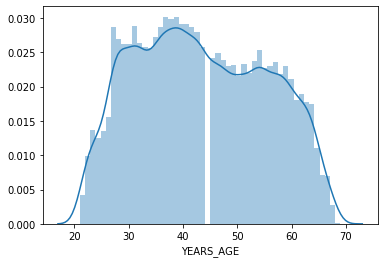

In [19]:
import seaborn as sns

sns.distplot(app_train_test["YEARS_AGE"])

### Checking ~Intersection Columns between Table

In [17]:
def not_intersect_cols(df1, df2):
    set_cols1 = set(df1.columns)
    set_cols2 = set(df2.columns)
    new_cols = set(set_cols2.union(set_cols1) - set_cols1.intersection(set_cols2))
    new = new_cols - set_cols1
    return list(new)

In [18]:
not_intersect_cols(app_train_test, prev_app)

['YIELD_GROUP',
 'NFLAG_INSURED_ON_APPROVAL',
 'CONTRACT_STATUS',
 'DAYS_DECISION',
 'TERMINATION',
 'CONTRACT_TYPE',
 'APPLICATION',
 'AMT_DOWN_PAYMENT',
 'SK_ID_PREV',
 'TERM_PAYMENT',
 'FIRST_DRAW',
 'WEEKDAYS_APPLY',
 'FIRST_DUE']

In [19]:
not_intersect_cols(app_train_test, installment_pmt)

['INST_DAYS', 'PAY_DAYS', 'INST_NUMBER', 'AMT_PAY', 'SK_ID_PREV', 'AMT_INST']

In [20]:
not_intersect_cols(prev_app, installment_pmt)

['INST_DAYS', 'PAY_DAYS', 'INST_NUMBER', 'AMT_PAY', 'AMT_INST']

### Preprocessing Prev_App Data

In [21]:
prev_app = prev_app.sort_values(by=["LN_ID","SK_ID_PREV"])

In [22]:
prev_app["FIRST_DRAW"].replace(365243, np.nan, inplace=True)
prev_app["FIRST_DUE"].replace(365243, np.nan, inplace=True)
prev_app["TERMINATION"].replace(365243, np.nan, inplace=True)

In [23]:
prev_app["CREDIT_PERC"] = prev_app["APPLICATION"] / prev_app["APPROVED_CREDIT"]

In [24]:
num_aggregations = {"ANNUITY": ["max", "mean"],
                    "APPLICATION": ["min", "mean"],
                    "CREDIT_PERC": ["min", "max", "mean"],
                    "APPROVED_CREDIT": ["min", "max", "mean"],
                    "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
                    "PRICE": ["min", "max", "mean"],
                    "HOUR_APPLY": ["min", "max", "mean"],
                    "DAYS_DECISION": ["min", "max", "mean"],
                    "TERM_PAYMENT": ["mean", "sum"],
                    "FIRST_DRAW": ["min", "max", "mean"],
                    "FIRST_DUE": ["min", "max", "mean"],
                    "TERMINATION": ["min", "max", "mean"]}

In [25]:
prev_app["NFLAG_INSURED_ON_APPROVAL"] = prev_app["NFLAG_INSURED_ON_APPROVAL"].astype("object")

In [26]:
cat_cols = [col for col in prev_app.columns if prev_app[col].dtype == "object"]
cat_feats = CategoricalFeatures(prev_app,
                                categorical_features=cat_cols,
                                encoding_type="one_hot",
                                handle_na=True)
df_transformed = cat_feats.fit_transform()
df_transformed = df_transformed.loc[:,~df_transformed.columns.duplicated()] # delete duplicate columns
new_cols = [c for c in df_transformed.columns if c not in prev_app.columns]

In [27]:
cat_aggregations = {}
for cat in new_cols:
    cat_aggregations[cat] = ["mean"]

In [28]:
prev_agg = df_transformed.groupby("LN_ID").agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(["PREV_" + c[0] + "_" + c[1].upper() for c in prev_agg.columns.tolist()])

Previous Applications: Approved Applications - only numerical features

In [29]:
approved = df_transformed[df_transformed["CONTRACT_STATUS_Approved"] == 1]
approved_agg = approved.groupby("LN_ID").agg(num_aggregations)
approved_agg.columns = pd.Index(["APPROVED_" + c[0] + "_" + c[1].upper() for c in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how="left", on="LN_ID")

Previous Applications: Refused Applications - only numerical features

In [30]:
refused = df_transformed[df_transformed["CONTRACT_STATUS_Refused"] == 1]
refused_agg = refused.groupby("LN_ID").agg(num_aggregations)
refused_agg.columns = pd.Index(["REFUSED_" + c[0] + "_" + c[1].upper() for c in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how="left", on="LN_ID")

### Preprocessing Installment_Pmt Data

In [31]:
installment_pmt = installment_pmt.sort_values(by=["LN_ID","SK_ID_PREV","INST_NUMBER"])

In [32]:
installment_pmt["PAYMENT_PERC"] = installment_pmt["AMT_PAY"] / installment_pmt["AMT_INST"]
installment_pmt["PAYMENT_DIFF"] = installment_pmt["AMT_PAY"] - installment_pmt["AMT_INST"]

In [33]:
installment_pmt["OVERDUE_DAYS"] = installment_pmt["PAY_DAYS"] - installment_pmt["INST_DAYS"]

# has due on each installment_pmt or not
has_due = installment_pmt["OVERDUE_DAYS"] > 0
hasnt_due = installment_pmt["OVERDUE_DAYS"] <= 0

# create new feature
installment_pmt.loc[has_due, "HAS_DUE"] = 1
installment_pmt.loc[hasnt_due, "HAS_DUE"] = 0

In [34]:
# aggregations
aggregations = {"INST_NUMBER": ["nunique"],
                "INST_DAYS": ["max", "mean", "sum"],
                "PAY_DAYS": ["max", "mean", "sum"],
                "AMT_INST": ["max", "mean", "sum"],
                "AMT_PAY": ["min", "max", "mean", "sum"],
                "PAYMENT_PERC": ["mean", "sum", "var"],
                "PAYMENT_DIFF": ["mean", "sum", "var"],
                "OVERDUE_DAYS": ["min", "max", "mean"],
                "HAS_DUE": ["max", "mean", "sum"]}

In [35]:
cat_cols = [col for col in installment_pmt.columns if installment_pmt[col].dtype == "object"]
cat_feats = CategoricalFeatures(installment_pmt,
                                categorical_features=cat_cols,
                                encoding_type="one_hot",
                                handle_na=True)
df_transformed = cat_feats.fit_transform()
new_cols = [c for c in df_transformed.columns if c not in installment_pmt.columns]
df_transformed = df_transformed.loc[:,~df_transformed.columns.duplicated()] # delete duplicate columns if any

In [36]:
for cat in new_cols:
    aggregations[cat] = ["mean"]

In [37]:
installment_agg = df_transformed.groupby("LN_ID").agg(aggregations)
installment_agg.columns = pd.Index(['INSTAL_' + c[0] + "_" + c[1].upper() for c in installment_agg.columns.tolist()])
installment_agg["INSTAL_COUNT"] = df_transformed.groupby('LN_ID').size()

### Joining All the Data

In [38]:
installment_agg.reset_index(inplace=True)
prev_agg.reset_index(inplace=True)
app_train_test.reset_index(drop=True, inplace=True)

In [39]:
app_train_test.TARGET.value_counts(normalize=True)

0   0.9191
1   0.0809
Name: TARGET, dtype: float64

In [40]:
df_ = app_train_test.merge(prev_agg, how="left", on="LN_ID")

In [41]:
df_ = df_.merge(installment_agg, how="left", on="LN_ID")

In [42]:
df_.tail()

,LN_ID,TARGET,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,NEW_ANNUITY_TO_CREDIT_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_INCOME_BY_ORG,NEW_EMPLOYED_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_CREDIT_TO_INCOME_RATIO,NEW_GOODS_TO_INCOME_RATIO,NEW_SCORE_PROD,NEW_EXT_SCORES_MEAN,NEW_EXT_SCORES_STD,NEW_INC_PER_PERSON,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CONTRACT_TYPE_nan,GENDER_F,GENDER_M,GENDER_nan,INCOME_TYPE_Businessman,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Student,INCOME_TYPE_Unemployed,INCOME_TYPE_Working,INCOME_TYPE_nan,EDUCATION_Academic degree,EDUCATION_Higher education,EDUCATION_Incomplete higher,EDUCATION_Lower secondary,EDUCATION_Secondary / secondary special,EDUCATION_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,...,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_PRICE_MIN,REFUSED_PRICE_MAX,REFUSED_PRICE_MEAN,REFUSED_HOUR_APPLY_MIN,REFUSED_HOUR_APPLY_MAX,REFUSED_HOUR_APPLY_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_TERM_PAYMENT_MEAN,REFUSED_TERM_PAYMENT_SUM,REFUSED_FIRST_DRAW_MIN,REFUSED_FIRST_DRAW_MAX,REFUSED_FIRST_DRAW_MEAN,REFUSED_FIRST_DUE_MIN,REFUSED_FIRST_DUE_MAX,REFUSED_FIRST_DUE_MEAN,REFUSED_TERMINATION_MIN,REFUSED_TERMINATION_MAX,REFUSED_TERMINATION_MEAN,INSTAL_INST_NUMBER_NUNIQUE,INSTAL_INST_DAYS_MAX,INSTAL_INST_DAYS_MEAN,INSTAL_INST_DAYS_SUM,INSTAL_PAY_DAYS_MAX,INSTAL_PAY_DAYS_MEAN,INSTAL_PAY_DAYS_SUM,INSTAL_AMT_INST_MAX,INSTAL_AMT_INST_MEAN,INSTAL_AMT_INST_SUM,INSTAL_AMT_PAY_MIN,INSTAL_AMT_PAY_MAX,INSTAL_AMT_PAY_MEAN,INSTAL_AMT_PAY_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_OVERDUE_DAYS_MIN,INSTAL_OVERDUE_DAYS_MAX,INSTAL_OVERDUE_DAYS_MEAN,INSTAL_HAS_DUE_MAX,INSTAL_HAS_DUE_MEAN,INSTAL_HAS_DUE_SUM,INSTAL_COUNT
76259,144293,0,1,67500.0000,112500.0000,7317.0000,112500.0000,-12866,-3154.0000,-1251.0000,-4395,10,0.5703,0.3996,0.5867,0.0650,1.0000,135000.0000,0.2451,0.1084,1.6667,1.6667,0.1337,0.5189,0.1036,33750.0000,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.0000,-5.0000,-837.2683,-34328.0000,-36.0000,-855.9268,-35093.0000,22143.9600,4591.4620,188249.9400,2517.5250,22143.9600,4702.2059,192790.4400,1.1161,45.7585,0.5023,110.7439,4540.5000,350313.2187,-34.0000,-2.0000,-18.6585,0.0000,0.0000,0.0000,41.0000
76260,272093,1,1,135000.0000,313438.5000,21073.5000,283500.0000,-11421,-3962.0000,-5247.0000,-3795,7,nan,0.6108,0.3690,0.0672,1.1056,148500.0000,0.3469,0.1561,2.3218,2.1000,nan,0.4899,0.1710,67500.0000,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,nan,nan,nan,630000.0000,630000.0000,630000.0000,6.0000,6.0000,6.0000,-211.0000,-211.0000,-211.0000,36.0000,36.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.0000,-191.0000,-1101.7273,-24238.0000,-200.0000,-1108.8182,-24394.0000,21013.6050,13069.8777,287537.3100,3497.8950,21013.6050,13069.8777,287537.3100,1.0000,22.0000,0.0000,0.0000,0.0000,0.0000,-20.0000,0.0000,-7.0909,0.0000,0.0000,0.0000,22.0000
76261,251117,0,0,157500.0000,1078200.0000,31522.5000,900000.0000,-13313,-2258.0000,-3899.0000,-4515,12,nan,0.6398,0.7826,0.0292,1.1980,157500.0000,0.1696,0.2001,6.8457,5.7143,nan,0.7112,0.1010,157500.0000,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.0000,-342.0000,-1105.3382,-75163.0000,-369.0000,-1115.7647,-75872.0000,447571.9800,23192.3508,1577079.8550,101.2500,447571.9800,17787.8051,1209570.7500,0.7500,51.0000,0.1435,-5404.5457,-367509.1050,96007304.9281,-70.0000,37.0000,-10.4265,1.0000,0.3088,21.0000,68.0000
76262,334313,

### Model Training (Manual Version)

In [43]:
train_len = len(app_train)
train_df = df_.iloc[:train_len, :]
test_df = df_.iloc[train_len:, :]
feats = [f for f in train_df.columns if f not in ["LN_ID", "TARGET"]]
x = train_df[feats]
y = train_df["TARGET"]

In [45]:
from sklearn.model_selection import train_test_split

def split_x_y(x, y, random_state):
    x_train,x_rest,y_train,y_rest = train_test_split(x,y,test_size=0.3,random_state=random_state)
    x_test,x_validation,y_test,y_validation = train_test_split(x_rest,y_rest,test_size=0.5,random_state = random_state*2)
    X = dict(
            train = x_train,
            test = x_test,
            validation = x_validation
        )
    Y = dict(
            train = y_train >0,
            test = y_test >0,
            validation = y_validation >0
        )
    return X,Y

X, Y = split_x_y(x,y,42)

In [46]:
print('Benchmark for data training: ', Y['train'].value_counts())
print('Benchmark for data testing: ', Y['test'].value_counts())

Benchmark for data training:  False    39555
True      3497
Name: TARGET, dtype: int64
Benchmark for data testing:  False    8482
True      743
Name: TARGET, dtype: int64


In [47]:
from xgboost import XGBClassifier

param = {
    'colsample_bytree': 0.758329634688253,
    'gamma': 0.20600454178220828,
    'max_depth': 5,
    'min_child_weight': 2,
    'reg_alpha': 100,
    'subsample': 0.7,
    'scale_pos_weight': 11.3
}

model_xgbt = XGBClassifier(**param, n_estimators = 2000)
eval_set  = [(X['train'], Y['train']), (X['test'], Y['test'])]
model_xgbt.fit(X['train'], Y['train'].values, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=15)

[0]	validation_0-auc:0.734483	validation_1-auc:0.711027
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.746102	validation_1-auc:0.717326
[2]	validation_0-auc:0.751172	validation_1-auc:0.722658
[3]	validation_0-auc:0.754314	validation_1-auc:0.72562
[4]	validation_0-auc:0.757054	validation_1-auc:0.728249
[5]	validation_0-auc:0.762121	validation_1-auc:0.731529
[6]	validation_0-auc:0.764294	validation_1-auc:0.732987
[7]	validation_0-auc:0.767017	validation_1-auc:0.735909
[8]	validation_0-auc:0.768246	validation_1-auc:0.736201
[9]	validation_0-auc:0.77009	validation_1-auc:0.737577
[10]	validation_0-auc:0.771706	validation_1-auc:0.738454
[11]	validation_0-auc:0.773181	validation_1-auc:0.740374
[12]	validation_0-auc:0.775179	validation_1-auc:0.741992
[13]	validation_0-auc:0.776863	validation_1-auc:0.743539
[14]	validation_0-auc:0.778263	validation_1-auc:0.743986


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.758329634688253,
              gamma=0.20600454178220828, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=2, missing=None, n_estimators=2000,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=100, reg_lambda=1,
              scale_pos_weight=11.3, seed=None, silent=None, subsample=0.7,
              verbosity=1)

In [ ]:
# import pickle

# df, y_actual = pickle.load(open("preprocessed_data", "rb"))
# test_df = df[df["TARGET"].isnull()]
# feats = [f for f in df.columns if f not in ["LN_ID", "TARGET"]]
# model_xgbt = pickle.load(open("model_xgbt_v1", "rb"))

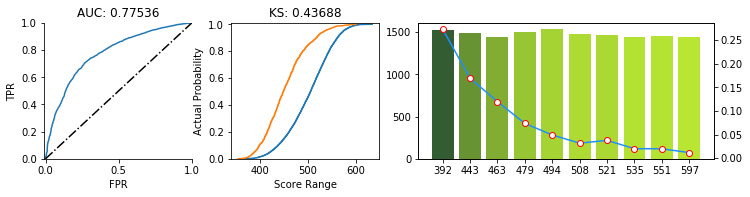

In [52]:
%matplotlib inline
from script.scorer import Scorer
import analytic.plot as plot
import math
import pandas as pd

score = Scorer(min_score=300, max_score=850, pdo=30, base_odds=math.exp(3), base=600)

def extract_score(prob):
    return score.to_score(prob[1])

y_actual = test_df["TARGET"]

tmp = list(map(lambda x: extract_score(x),model_xgbt.predict_proba(test_df[feats])))
t1 = plot.plot_triple(pd.Series(tmp), y_actual>0, 10, table=True)

In [53]:
t1

,Score Range,Proportion,Bad Rate,Cumulative of Total Proportion,Cumulative of Good Proportion,Cumulative of Bad Proportion,ks
0,"(353.999, 432.0]",0.1034,0.2731,0.1034,0.0819,0.3466,0.2648
1,"(432.0, 455.0]",0.1010,0.1690,0.2045,0.1733,0.5561,0.3829
2,"(455.0, 472.0]",0.0974,0.1196,0.3019,0.2666,0.6991,0.4325
3,"(472.0, 487.0]",0.1013,0.0736,0.4032,0.3688,0.7905,0.4217
4,"(487.0, 502.0]",0.1037,0.0490,0.5068,0.4761,0.8529,0.3768
5,"(502.0, 515.0]",0.1001,0.0318,0.6069,0.5816,0.8919,0.3103
6,"(515.0, 528.0]",0.0989,0.0377,0.7058,0.6853,0.9377,0.2524
7,"(528.0, 542.0]",0.0978,0.0201,0.8036,0.7896,0.9618,0.1722
8,"(542.0, 560.0]",0.0987,0.0199,0.9023,0.8949,0.9859,0.0910
9,"(560.0, 634.0]",0.0977,0.0118,1.0000,1.0000,1.0000,0.0000


Text(0.5, 1, 'Confusion Matrix')

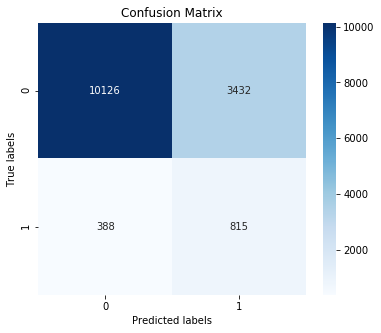

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# classification report to dataframe
report = classification_report(y_actual, model_xgbt.predict(test_df[feats]), output_dict=True)
df_report = pd.DataFrame(report).transpose()

# confusion matrix plot
plt.figure(figsize=(6,5))
ax = plt.subplot()
cm = confusion_matrix(y_actual, model_xgbt.predict(test_df[feats]))
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt="g"); #annot=True to annotate cells

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
# plt.savefig('plot_confusion_matrix.png')

In [55]:
df_report

,precision,recall,f1-score,support
0,0.9631,0.7469,0.8413,13558.0000
1,0.1919,0.6775,0.2991,1203.0000
accuracy,0.7412,0.7412,0.7412,0.7412
macro avg,0.5775,0.7122,0.5702,14761.0000
weighted avg,0.9002,0.7412,0.7971,14761.0000
